In [9]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline

import pandas as pd
from survival import evaluate_test_stats, _evaluate_test_stats

import sys
sys.path.append('phase_transition_experiment/')
from sample_survival_poisson import sample_survival_poisson

seed = 0
np.random.seed(seed)

## Synthetic experiment

Sample data from rare and weak exponential decay and compare several test statistics

To do:
 - Under the aternative, check if hypergeometric P-values are equally small across all time intervals. 

In [2]:
T = 100
N1 = N2 = 1000
lam0 = 1.5
r = 1.2
beta = 0.7
stbl = True
alternative = 'two-sided'
lam = lam0 * np.ones(T) / T

In [3]:
import hashlib
def hash_parameters(parameters, digits=10):
    # Convert the parameters to a string representation
    parameters_str = str(parameters)

    # Hash the string representation using SHA-256
    hash_object = hashlib.sha256(parameters_str.encode())

    # Get the hexadecimal representation of the hash value
    hash_value = hash_object.hexdigest()

    return hash_value[:digits]


In [5]:
# ##### Null data

#Null Parameters:  {'alternative': 'two-sided', 'T': 100, 'N1': 1000, 'N2': 1000, 'lam0': 1.5, 'nMonte': 10000}
#Reading null data from file results/synthetic_data_null_3eb54ab33d.csv
nMonte_null = 10000
params_null = dict(alternative=alternative, T = T, N1 = N1, N2 = N2, lam0 = lam0, nMonte = nMonte_null)
print("Null Parameters: ", params_null)
fn = f"results/synthetic_data_null_{hash_parameters(params_null)}.csv"

print(f"Reading null data from file {fn}")
df0 = pd.read_csv(fn, index_col=0)
results0 = df0.to_dict()
print(f"Found results of {len(df0)} Monte Carlo iterations with {len(results0)} satistics.")
df0 = pd.read_csv(fn, index_col=0)

Null Parameters:  {'alternative': 'two-sided', 'T': 100, 'N1': 1000, 'N2': 1000, 'lam0': 1.5, 'nMonte': 10000}
Reading null data from file results/synthetic_data_null_3eb54ab33d.csv
Found results of 10000 Monte Carlo iterations with 14 satistics.


In [13]:
from lifelines.statistics import multivariate_logrank_test

Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam, eps=T**(-beta), r=r)
Ot1 = -np.diff(Nt1).astype(int)
Ot2 = -np.diff(Nt2).astype(int)
# N1 = Nt1[0]
# N2 = Nt2[0]
# Ct1 = (-np.diff(Nt1) - Ot1).astype(int)
# Ct2 = (-np.diff(Nt2) - Ot2).astype(int)
# Ct1[-1] = Ct1[-1] + N1 - Ot1.sum()
# Ct2[-1] = Ct2[-1] + N2 - Ot2.sum()

# assert np.all(Ct1 >= 0)
# assert np.all(Ct2 >= 0)

dfg = pd.DataFrame({'observed:0' : Ot1, 'observed:1': Ot2, 'censored:0': Ct1, 'censored:1': Ct2})

results = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2)

In [8]:
# try evalaute HCstar
nMonte = 10000
from survival import multi_pvals

results = {}
for itr in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam, eps=0.5, r=0)
    Ot1 = -np.diff(Nt1).astype(int)
    Ot2 = -np.diff(Nt2).astype(int)
    res1 = _evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2,
                            alternative='greater')
    res2 = _evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2,
                            alternative='two-sided')
    new_keys = [k + '_two-sided' for k in res2]
    
    res2 = dict(zip(new_keys, res2.values()))
    results[itr] = {**res1, **res2}
df0s = pd.DataFrame(results).T

100%|██████████| 10000/10000 [00:45<00:00, 218.71it/s]


In [37]:
df0.to_csv(fn)

In [36]:
len(df0.columns)

16

In [32]:
['log_rank_two-sided', 'log_rank_pval_two-sided', 'hc_two-sided',
       'fisher_two-sided', 'min_p_two-sided', 'berk_jones_two-sided',
       'logrank_lifelines_None', 'logrank_lifelines_wilcoxon',
       'logrank_lifelines_tarone-ware', 'logrank_lifelines_peto',
       'logrank_lifelines_fleming-harrington55',
       'logrank_lifelines_fleming-harrington11',
       'logrank_lifelines_fleming-harrington01', 'chisq_test_stat',
       'lr_test_stat', 'cauchy_test_stat']

['log_rank_two-sided',
 'log_rank_pval_two-sided',
 'hc_two-sided',
 'fisher_two-sided',
 'min_p_two-sided',
 'berk_jones_two-sided',
 'logrank_lifelines_None',
 'logrank_lifelines_wilcoxon',
 'logrank_lifelines_tarone-ware',
 'logrank_lifelines_peto',
 'logrank_lifelines_fleming-harrington55',
 'logrank_lifelines_fleming-harrington11',
 'logrank_lifelines_fleming-harrington01',
 'chisq_test_stat',
 'lr_test_stat',
 'cauchy_test_stat']

In [5]:
def q95(x):
    """
    The 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)

crit_vals = df0s.agg([q95])
crit_vals

,log_rank,log_rank_pval,hc,fisher,min_p,berk_jones,log_rank_two-sided,log_rank_pval_two-sided,hc_two-sided,fisher_two-sided,min_p_two-sided,berk_jones_two-sided
q95,1.675357,0.950621,1.082166,181.148551,6.394058,2.565558,1.978367,0.947292,1.214639,186.484814,6.990063,3.136546


In [18]:
beta = .7
r = 1.2
nMonte = 1000
alternative = 'two-sided'

eps = T ** (-beta)
lam = lam0 * np.ones(T) / T

results = {}
for itr in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam, eps, r)
    Ot1 = -np.diff(Nt1).astype(int)
    Ot2 = -np.diff(Nt2).astype(int)
    res1 = _evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2,
                            alternative='greater')
    res2 = _evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2,
                            alternative='two-sided', pvals_alternative='greater')
    new_keys = [k + '_two-sided' for k in res2]
    pvals_1s = multi_pvals(Nt1[:-1], Nt2[:-1], Ot1, Ot2, alternative='greater')
    
    res2 = dict(zip(new_keys, res2.values()))
    results[itr] = {**res1, **res2}
df1 = pd.DataFrame(results).T

100%|██████████| 1000/1000 [00:09<00:00, 100.74it/s]


In [20]:
# lo_stats = ['berk_jones_two-sided','hc_two-sided', 'min_p_two-sided', 'log_rank_two-sided', 'fisher_two-sided']
# for st in df1.columns:
#     if st+'_two-sided' in lo_stats:
#         df1.rename(columns={st: st+'_two-sided'}, inplace=True)

print("Evalauting number of discoveries...")
alpha = 0.05
no_dicoveries = {}
rate_dicoveries = {}
for st in df1.columns:
    if '_rev' in st:
        continue
    no_dicoveries[st] = np.sum(df1[st] > crit_vals[st].values[0])
    rate_dicoveries[st] = no_dicoveries[st] / len(df1)

print("Rate of discoveries:")
pd.DataFrame(rate_dicoveries, index=['rate']).T.sort_values('rate', ascending=False)

Evalauting number of discoveries...
Rate of discoveries:


,rate
berk_jones,0.642
min_p,0.583
hc,0.582
berk_jones_two-sided,0.565
hc_two-sided,0.509
fisher,0.503
min_p_two-sided,0.490
fisher_two-sided,0.435
log_rank,0.373
log_rank_two-sided,0.269


## Analyze results

In [13]:
fn = f"results/synthetic_data_T100_N1000_1cfc44f2ca.csv"
df1 = pd.read_csv(fn, index_col=0)
df1['min_p_two-sided'].quantile(0.95)

10.513574549186652

##### Null data

We use empirical 0.95 (for two-sided) quantiles of the test statistics obtained over ``nMonte`` samples from the null model. 

In [1]:
# ##### Null data
fn = f"results/results/synthetic_data_null_c69b0797f5.csv"
print(f"Reading null data from file {fn}")
df0 = pd.read_csv(fn, index_col=0)
results0 = df0.to_dict()
print(f"Found results of {len(df0)} Monte Carlo iterations with {len(results0)} satistics.")
df0 = pd.read_csv(fn, index_col=0)

NameError: name 'alternative' is not defined

In [61]:
lo_stats = df1.columns
# you can specify critical values for each test if you do not wish to use null simulations
crit_vals_table = {'chisq_test_stat': 2.6288}
stat_1sided = ['hc_greater', 'min_p_greater', 'log_rank_greater', 'fisher_greater']

print("Columns of df0:", df0.columns)
print("Stats in lo_stats:", lo_stats)

print("Evalauting number of discoveries...")
alpha = 0.05
crit_vals = {}
no_dicoveries = {}
rate_dicoveries = {}
for st in lo_stats:
    if '_rev' in st:
        continue
    if st in crit_vals_table:
        crit_vals[st] = crit_vals_table[st]
    else:
        crit_vals[st] = df0[st].quantile(1 - alpha)
    if st in stat_1sided: # for one-sided test, must not report on cases of an effect in both ways
        no_dicoveries[st] = np.sum((df1[st] > crit_vals[st]))
    else:
        no_dicoveries[st] = np.sum(df1[st] > crit_vals[st])
    rate_dicoveries[st] = no_dicoveries[st] / len(df1)


print("Rate of discoveries:")
print(rate_dicoveries)
print("Latex table:")
print(pd.DataFrame.from_dict(rate_dicoveries, orient='index').sort_values([0],ascending=False).to_latex())

Columns of df0: Index(['log_rank_greater', 'log_rank_pval_greater', 'hc_greater',
       'fisher_greater', 'min_p_greater', 'berk_jones_greater',
       'logrank_lifelines_None', 'logrank_lifelines_wilcoxon',
       'logrank_lifelines_tarone-ware', 'logrank_lifelines_peto',
       'logrank_lifelines_fleming-harrington55',
       'logrank_lifelines_fleming-harrington11',
       'logrank_lifelines_fleming-harrington01', 'chisq_test_stat',
       'lr_test_stat', 'cauchy_test_stat'],
      dtype='object')
Stats in lo_stats: Index(['log_rank_greater', 'log_rank_pval_greater', 'hc_greater',
       'fisher_greater', 'min_p_greater', 'berk_jones_greater',
       'logrank_lifelines_None', 'logrank_lifelines_wilcoxon',
       'logrank_lifelines_tarone-ware', 'logrank_lifelines_peto',
       'logrank_lifelines_fleming-harrington55',
       'logrank_lifelines_fleming-harrington11',
       'logrank_lifelines_fleming-harrington01', 'chisq_test_stat',
       'lr_test_stat', 'cauchy_test_stat'],
     

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_16572/2182259318.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(rate_dicoveries, orient='index').sort_values([0],ascending=False).to_latex())


In [65]:
print(pd.DataFrame.from_dict(rate_dicoveries,orient='index').sort_values([0],ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
hc\_greater                             &  0.721 \\
fisher\_greater                         &  0.668 \\
min\_p\_greater                          &  0.625 \\
log\_rank\_greater                       &  0.530 \\
logrank\_lifelines\_None                 &  0.426 \\
cauchy\_test\_stat                       &  0.424 \\
lr\_test\_stat                           &  0.420 \\
logrank\_lifelines\_fleming-harrington55 &  0.414 \\
logrank\_lifelines\_fleming-harrington11 &  0.409 \\
logrank\_lifelines\_tarone-ware          &  0.405 \\
logrank\_lifelines\_wilcoxon             &  0.384 \\
logrank\_lifelines\_peto                 &  0.383 \\
logrank\_lifelines\_fleming-harrington01 &  0.383 \\
chisq\_test\_stat                        &  0.348 \\
berk\_jones\_greater                     &  0.016 \\
log\_rank\_pval\_greater                  &  0.000 \\
\bottomrule
\end{tabular}



/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_16572/1067421056.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(rate_dicoveries,orient='index').sort_values([0],ascending=False).to_latex())


<Axes: >

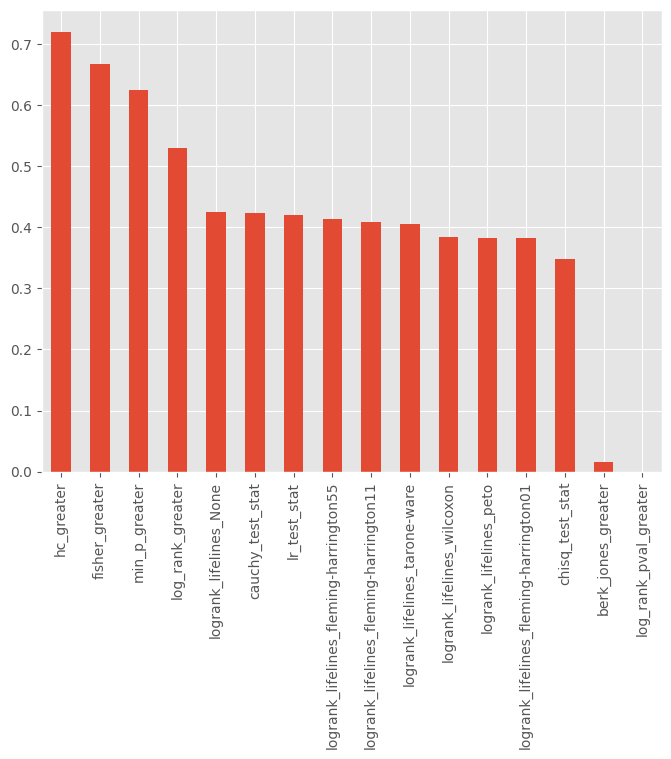

In [62]:
pd.DataFrame.from_dict(rate_dicoveries,orient='index').sort_values([0],ascending=False).plot(kind='bar', legend=False)

In [ ]:
# function from multHG package

from multiHGtest import hypergeom_test
from multitest import MultiTest

def _multi_test(Nt1: list, Nt2: list, Ot1: list = None, Ot2: list = None, **kwargs):
    """
    Helper function to create a MultiTest object from two survival tables

       Args:
           Nt1:  number of at-risk subjects in group 1 per time
           Nt2:  number of at-risk subjects in group 2 per time
           Ot1:  number failure events in group 1 per time
           Ot2:  number of failure events in group 1 per time
           **kwargs:

       Returns:
           MultiTest object
       """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Nt1) == len(Ot2))

    randomize = kwargs.get('randomize', False)
    pvals_alternative = kwargs.get('pvals_alternative', 'greater')
    discard_ones = kwargs.get('discard_ones', False)

    pvals = hypergeom_test(Ot2, Nt2 + Nt1, Nt2, Ot1 + Ot2,
                           randomize=randomize, alternative=pvals_alternative)
    if discard_ones:
        return MultiTest(pvals[pvals<1])
    return MultiTest(pvals)


def hchg_test(Nt1: np.ndarray, Nt2: np.ndarray, Ot1=None, Ot2=None,
              alternative='two-sided', **kwargs):
    """
    higher criticism test of hypergeometric P-values for comparing survival data as
    described in: [1] Galili, Kipnis, Yakhini. 2023. Survival Analysis with Sensitivity to Rare and Weak Temporal
    Differences.

    To do:
     - Convert to time to event representation by default
     - Also allow Berk-Jones version

    Args:
        Nt1:  number of at-risk subjects in group 1 per time
        Nt2:  number of at-risk subjects in group 2 per time
        Ot1:  number failure events in group 1 per time; if Ot1 = None, then assume
              Ot1[i] = Nt1[i-1] - Nt1[i] (no censorship)
        Ot2:  number of failure events in group 1 per time; if Ot2 = None, then assume
              Ot2[i] = Nt2[i-1] - Nt2[i] (no censorship)
        **kwargs: additional arguments to be passed to the hypergeometric test


    Returns:
        HC test statistic

    """

    if Ot1 is None:
        Ot1 = -Nt1.diff()
        Nt1 = Nt1[:-1]
    if Ot2 is None:
        Ot2 = -Nt2.diff()
        Nt2 = Nt2[:-1]

    gamma = kwargs.get('gamma', 0.2) # another option is 'auto' 

    if alternative == 'greater': # excessive hazard in Group 2
        mtest = _multi_test(Nt1, Nt2, Ot1, Ot2, **kwargs)
        hc = mtest.hc_star(gamma)[0]
    elif alternative == 'less': # excessive hazard in Group 1
        mtest = _multi_test(Nt2, Nt1, Ot2, Ot1, **kwargs)
        hc = mtest.hc_star(gamma)[0]
    elif alternative == 'two-sided':
        mtest1 = _multi_test(Nt1, Nt2, Ot1, Ot2, **kwargs)
        mtest2 = _multi_test(Nt2, Nt1, Ot2, Ot1, **kwargs)
        hc = np.maximum(mtest1.hc_star(gamma)[0], mtest2.hc_star(gamma)[0])
    else:
        raise ValueError("alternative must be one of 'greater', 'less', or 'two-sided'")
    return hc
